# Data Augmentation - LARGE

#### IMPORTS

In [1]:
#THIS is the third scaled iteration of augmentation and modeling assessments

import pandas as pd
import re
import warnings
from itertools import combinations
from nltk import bigrams  # Make sure to install the nltk library: pip install nltk
import classes_and_methods.soam_class as soam #contains a text cleaning method
import classes_and_methods.title_data_augmenter_class as augment
from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

1068 lines from "Augement_Equipment_OPT" file downloaded for supplement
"Augement_NOCTILUCENT_CLOUDS_Wiki" string downloaded for supplement
89 lines from "Augement_NOCTILUCENT_CLOUDS_GPT" file downloaded for supplement
73 lines from "Augement_NORTHERN_LIGHTS_GPT" file downloaded for supplement


### SET PARAMETERS

In [2]:
size = 100000

#Optimization parameters -- dropping 'char' from gram_types
optimize_params = {
    "gram_types":['word'], #must be 'word', 'char', or both
    "ngram_options": [1,2], #must be sorted in order [1,2,3]
    "smoothing_factor_steps":[round(x*0.1, 1) for x in range(1, 6 +1)],#[round(x*0.1, 1) for x in range(0, 10 +1)], # in range --> 0 = 0.0, 5 = 0.5, 10 = 1.0
    #"smoothing_factor_steps":[round((x)*0.02+0.2, 2) for x in range(0, 30 +1)], #for fine tuning if needed...
    "model_choices":[
        RandomForestClassifier(),
        LinearSVC()
    ]
}

In [3]:
#Helper Methods
def category_counts(df, cat_col, print_it = True):
    """
    Provided a data frame, df, and a category column name, cat_col...
        Print a table showing the categories and their corresponding:
            -Category name
            -Category record count
            -Percentage across all categories
    """
    # Get the value counts and create a DataFrame
    table = pd.DataFrame(df[cat_col].value_counts()).reset_index()
    # Rename the columns for clarity
    table.columns = ['Subject', 'Count']
    #set percentages column
    total = sum(table['Count'])
    table['Percentages'] = table['Count']/total
    if(print_it):
        # Display the table
        print("Table of subject_type Counts:")
        print(table)
        print(f'TOTAL = {total}')
    
    return table

def two_category_histogram(category1, category2, total_counts, df, print_it = False):
    """
    Where:
        - string category1 counts will be represented as a single bar
        - string ategory2 counts within category1 will be represented by 
            color on the corresponding category1 bar
        - string total_counts is a column containing counts of occurance within both categories
        - df is a data frame with category1 and category2 two columns
    """
    # Create a cross-tabulation (count) of Category1 and Category2
    
    cross_tab = df.pivot_table(index=category1, columns=category2, values=total_counts, aggfunc='sum')

    # Sort the DataFrame based on the counts of Category1 in descending order
    sorted_cross_tab = cross_tab.sum(axis=1).sort_values(ascending=False)
    cross_tab_sorted = cross_tab.loc[sorted_cross_tab.index]

    # Plot the histogram-like graph
    ax = cross_tab_sorted.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')
    
    # Set the y-axis limit to be 20% greater than the second largest subject type
    y_limit = 1.2 * sorted_cross_tab.iloc[1]
    plt.ylim(0, y_limit)

    # Annotate bars that exceed the y-axis limit
    for i, (idx, row) in enumerate(cross_tab_sorted.iterrows()):
        if row.sum() > y_limit:
            ax.annotate(f'** / / **', xy=(i, y_limit), ha='center', va='bottom', color='red')
        
    # Customize the plot
    ax.set_xlabel(category1.upper())
    ax.set_ylabel('Count')
    ax.legend(title = category2.upper(), bbox_to_anchor=(1, 1))
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    
    # Tilt x-axis tick labels at a 45-degree angle
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
    
    if print_it == True:
        # Show the plot
        print("PLOTTING CATEGORIES")
        plt.show()
    
    return(plt)

print("METHODS READY ---")
print("def two_category_histogram(category1, category2, df, print_it = False)")
print("def category_counts(df, cat_col, print_it = True)")

METHODS READY ---
def two_category_histogram(category1, category2, df, print_it = False)
def category_counts(df, cat_col, print_it = True)


### Original Data

In [4]:
# Data Load (provided by Salvatore from AstroBin site)
df = pd.read_csv("data/astrobin_titles_to_subject_types.csv") #the main starting data frame
#set data types
df['subject_type'] = df['subject_type'].astype('category') #subject_type is our pre-defined categories
df['title'] = df['title'].astype(str) #title is our text data
#data set cleaning
df = df.dropna(how='all') #droping only the rows with 'na' across ALL columns
df = df.dropna(subset=['title']) #droping only the rows with 'na' ONLY in title column
df = df[df['title'] != 'nan'] #droping only the rows with 'nan' ONLY in title column
df = df[~df['title'].str.isspace()] #droping only the rows with just '  ' (white space) as title
df = df[df['title']!=''] #droping only the rows with just '' (dead space) as title
df = df.dropna(subset=['subject_type']) #droping only the rows with 'na' subject_type                                                
#cleaning out the odd '600' category, converting it to 'OTHER' (per email "Image Title Classification | AstroBin")
df['subject_type'] = df['subject_type'].replace('600','OTHER')
#title cleaning (text cleaning method can be reviewed in the appendix, referenced in imports)
df['cleaned_title'] = df['title'].apply(soam.provided_cleaning_method)

#Review the Original df
original_counts = category_counts(df,'subject_type')

Table of subject_type Counts:
              Subject   Count  Percentages
0            DEEP_SKY  444255     0.751298
1        SOLAR_SYSTEM  111233     0.188111
2          WIDE_FIELD   20108     0.034005
3               OTHER    9670     0.016353
4                GEAR    3587     0.006066
5         STAR_TRAILS    1628     0.002753
6     NORTHERN_LIGHTS     674     0.001140
7  NOCTILUCENT_CLOUDS     162     0.000274
TOTAL = 591317


## OPTIMIZATION SEARCH

In [5]:
def optimize_classifier(df, optimize_params, sample_size = -1):
    """
    Where:
        -- sample size is the number of sampled rows to take from the passed df.
        -- optimize_params is a dict containing a list of all options
            where the listed options each contain the following choices:
            - "gram_types":['char','word'], #must be 'word', 'char', or both
            - "ngram_options": [1,2], #must be sorted in order [1,2,3]
            - "smoothing_factor_steps":[round(x*0.1, 1) for x in range(0, 10 +1)], # in range --> 0 = 0.0, 5 = 0.5, 10 = 1.0
            - #"smoothing_factor_steps":[round((x)*0.02+0.2, 2) for x in range(0, 30 +1)], #for fine tuning if needed...
            - "model_choices":[ #example model choices ...
                MultinomialNB(),
                RandomForestClassifier(),
                LinearSVC(),
                LogisticRegression(solver='liblinear', multi_class='ovr') 
            ]
    """
    # HELPER Function to extract bigrams from a text
    def extract_bigrams(text):
        tokens = text.split()
        return list(bigrams(tokens))

    #collection bins........
    subject_type_counts = []
    model_names = []
    models = []
    reports = []
    accuracies = []
    
    data = {}
    data['data_characteristics'] = []
    #.......................
    
    #make df based on provided sample size
    df_sampled = None #default instantiated
    if sample_size>0:
        df_sampled = df.sample(n=sample_size)
    else:
        df_sampled = df
    original_counts = category_counts(df_sampled,'subject_type', print_it = False)
    
    #UNPACK smoothing_factor PARAMETERS:
    for smoothing_factor in optimize_params["smoothing_factor_steps"]:
        
        name = f"smooth_factor {smoothing_factor}"
        print("Working on smoothing data with",name) #TRACER 
        #1. AUGMENT THE DATA --------------------------------------
        #augment the df according to smoothing factor...
        df_augmented = augment.title_data_augmenter(
            df_sampled, original_counts, smoothing_factor, augment.supplement_params)
        # ---------------------------------------------------------
        
        # RUN Model ----------------------------------------------------
        # Step 1: Load and Preprocess Data
        train_data, test_data, train_labels, test_labels = train_test_split(
            df_augmented['title'], df_augmented['subject_type'], test_size=0.2, random_state=333)

        # Step 2: Feature Extraction
        
        #UNPACK ngram PARAMETERS:
        # -- options [1,2] provide ranges [(1, 1), (1, 2), (2, 2)]
        ngram_ranges = [(x,y) for y in optimize_params["ngram_options"] 
                         for x in optimize_params["ngram_options"] if y>=x]
        
        #with given params, build vectorizer options
        vectorizer_options = []
        for gram in optimize_params["gram_types"]:
            for ngram_range in ngram_ranges:
                if gram == 'char':
                    vectorizer_options.append(
                        TfidfVectorizer(ngram_range=ngram_range, analyzer='char')
                    )
                else:
                    vectorizer_options.append(
                        TfidfVectorizer(ngram_range=ngram_range)
                    )
        current_name = name
        for vectorizer in vectorizer_options:
            train_features = vectorizer.fit_transform(train_data)
            test_features = vectorizer.transform(test_data)
            
            for m in optimize_params["model_choices"]:
                name = f"{m} - {vectorizer} " + current_name
                # print(name) ##############################################
                # Step 3: Train a Classification Model
                classifier = m
                classifier.fit(train_features, train_labels)
                
                # Step 4: Make Predictions
                pred = classifier.predict(test_features) ##########
                
                # Step 5: Collect Metrics
                # Temporarily suppress warnings during the following:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    # -- general report
                    report = classification_report(test_labels, pred)
                    # -- accuracy: The proportion of correctly classified instances out of the total 
                    accuracy = accuracy_score(test_labels, pred)
                    # -- precision: The ratio of correctly predicted positive observations to the total predicted positives.
                    # -- recall (Sensitivity or True Positive Rate): The ratio of correctly predicted positive observations to the all observations in actual class.
                    # -- f1-Score: The weighted average of precision and recall. It is a good metric when there is an uneven class distribution.
                    f1 = f1_score(test_labels, pred, average='weighted')
                #collect the model data
                data[name] = {
                    "classifier":classifier,
                    "report":report,
                    "accuracy":accuracy,
                    "f1_score":f1,
                    'vectorizer':vectorizer
                }
            # ---------------------------------------------------------------

        #N. Get new augment counts ------------------------------
        
        # Calculate the top 5 bigrams for each combination of 'subject_type' and 'augmentation'
        result_data = []
        for (a, b), group_df in df_augmented.groupby(['subject_type', 'augmentation']):
            titles = group_df['title']
            all_bigrams = [bigram for title in titles for bigram in extract_bigrams(title)]
            top_bigrams = Counter(all_bigrams).most_common(5)
            result_data.append({'subject_type': a, 
                                'augmentation': b, 
                                'Top_Bigrams': top_bigrams,
                                'Total_Counts': len(titles)
                               })

        # Create a new DataFrame from the result
        result_df = pd.DataFrame(result_data)
        # Add a new DataFrame from the result
        data['data_characteristics'].append(
            {f'data_characteristics smoothed ({smoothing_factor})':result_df}
        )
        #--------------------------------------------------
    return(data)

In [6]:
#collect all models and corresponding data
print("Has it returned yet?")
the_return = optimize_classifier(df, optimize_params, sample_size= size) #for size see the top of this file
print("It has returned ... ")

Has it returned yet?
Working on smoothing data with smooth_factor 0.1
Working on smoothing data with smooth_factor 0.2
Working on smoothing data with smooth_factor 0.3
Working on smoothing data with smooth_factor 0.4
Working on smoothing data with smooth_factor 0.5
Working on smoothing data with smooth_factor 0.6
It has returned ... 


### UNPACKING THE MODELS and DATA

In [7]:
# UNPACK models
# Create a new dictionary without the specified key
all_models = {key: value for key, value in the_return.items() 
              if 'data_characteristics' not in key}

In [8]:
# build a df of the model_names and their corresponding metrics
#metrics and data----
names = []
acc = []
f1 = []
macro_avg = [] #of the models percision across the various categories
#--------------------

model_names = list(all_models.keys())
for m in model_names:
    names.append(m)
    acc.append(all_models[m]['accuracy'])
    f1.append(all_models[m]['f1_score'])
    s = the_return[m]['report'] 
    pattern = r'macro avg\s+([0-9.]+)'
    macro_avg.append(float(re.search(pattern, s).group(1)))
    
# Create a DataFrame -----------------
metrics_df = pd.DataFrame({
    'model_names': names,
    'accuracy': acc,
    'f1_score':f1,
    'macro_avg':macro_avg
})
#--------------------------------------

#sort the df by accuracy
metrics_df = metrics_df.sort_values(by='accuracy')

In [9]:
#parse out categories and build the final df

smooth_factors = [x[-3:] for x in metrics_df['model_names']]
model_types = [x.split(' - ')[0] for x in metrics_df['model_names']]
vectorizer_types = [x.split(' - ')[1].split(' smooth')[0] for x in metrics_df['model_names']]

metrics_df['smoothing_factor'] = smooth_factors
metrics_df['model_types'] = model_types
metrics_df['vectorizer_types'] = vectorizer_types

metrics_df['smoothing_factor'] = metrics_df['smoothing_factor'].astype(float)
metrics_df['model_types'] = metrics_df['model_types'].astype('category')
metrics_df['vectorizer_types'] = metrics_df['vectorizer_types'].astype('category')
metrics_df

,model_names,accuracy,f1_score,macro_avg,smoothing_factor,model_types,vectorizer_types
34,RandomForestClassifier() - TfidfVectorizer(ngr...,0.828550,0.828043,0.91,0.6,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))"
28,RandomForestClassifier() - TfidfVectorizer(ngr...,0.839300,0.836268,0.91,0.5,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))"
22,RandomForestClassifier() - TfidfVectorizer(ngr...,0.844358,0.840041,0.91,0.4,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))"
35,"LinearSVC() - TfidfVectorizer(ngram_range=(2, ...",0.845600,0.845492,0.92,0.6,LinearSVC(),"TfidfVectorizer(ngram_range=(2, 2))"
16,RandomForestClassifier() - TfidfVectorizer(ngr...,0.847200,0.840180,0.91,0.3,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))"
10,RandomForestClassifier() - TfidfVectorizer(ngr...,0.858207,0.849981,0.90,0.2,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))"
29,"LinearSVC() - TfidfVectorizer(ngram_range=(2, ...",0.858800,0.857012,0.92,0.5,LinearSVC(),"TfidfVectorizer(ngram_range=(2, 2))"
23,"LinearSVC() - TfidfVectorizer(ngram_range=(2, ...",0.860707,0.857526,0.92,0.4,LinearSVC(),"TfidfVectorizer(ngram_range=(2, 2))"
17,"LinearSVC() - TfidfVectorizer(ngram_range=(2, ...",0.863550,0.858354,0.92,0.3,LinearSVC(),"TfidfVectorizer(ngram_range=(2, 2))"
4,RandomForestClassifier() - TfidfVectorizer(ngr...,0.867250,0.857132,0.89,0.1,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))"


In [10]:
## UNPACKING DATA CHARACTERISTICS
list_of_new = []
number_of_old = len(the_return['data_characteristics'])
for i in range(0,number_of_old):
    for s in the_return['data_characteristics'][i]:
        #instantiate a new df
        characteristics_df = None        
        #get data characteristics for the given smoothing factor
        characteristics_df = the_return['data_characteristics'][i][s]
        #identify the rows of original data vs supplemented
        characteristics_df['data_type'] = characteristics_df['augmentation'].apply(
            lambda x: 'original' if x == 'sampled' else 'supplement'
        )
        
        #aggregate the counts on the data_types within each subject_type
        characteristics_df = characteristics_df.groupby(['subject_type','data_type']).agg({'Total_Counts':'sum'}).reset_index()
        #make a temp_b df that is aggregated on subject_type for the sum of Total_Counts
        temp_b = characteristics_df.groupby(['subject_type']).agg(
            {'Total_Counts':'sum'}).reset_index()
        
        #merge the temp_b total subject_type counts into the characterics_df
        characteristics_df = pd.merge(
            characteristics_df, temp_b, 
            on='subject_type', how='left'
        )
        #make a data type percentage (of either percent original or percent supplemented) within the subject_type
        characteristics_df['data_percentage'] = characteristics_df['Total_Counts_x']/characteristics_df['Total_Counts_y']
        
        #given the smoothing factor string, extract the smoothing factor and append it to the df
        sf = float(re.search(r'\((.*?)\)', s).group(1))
        characteristics_df['smoothing_factor'] = [sf]*len(characteristics_df)
        
        #rename the count columns so the make sense
        characteristics_df.rename(
            columns={'Total_Counts_x': 'sub_counts', 
                     'Total_Counts_y': 'total_counts'}, inplace=True
        )
        list_of_new.append(characteristics_df)

#Concatinate all new dfs
characteristics_df = pd.concat(list_of_new, ignore_index=True)
# Drop the bigrams column (not needed)
#characteristics_df = characteristics_df.drop('Top_Bigrams', axis=1)

characteristics_df

,subject_type,data_type,sub_counts,total_counts,data_percentage,smoothing_factor
0,DEEP_SKY,original,68845,68845,1.000000,0.1
1,GEAR,original,577,1768,0.326357,0.1
2,GEAR,supplement,1191,1768,0.673643,0.1
3,NOCTILUCENT_CLOUDS,original,29,1277,0.022709,0.1
4,NOCTILUCENT_CLOUDS,supplement,1248,1277,0.977291,0.1
...,...,...,...,...,...,...
79,SOLAR_SYSTEM,original,15010,15010,1.000000,0.6
80,STAR_TRAILS,original,276,7610,0.036268,0.6
81,STAR_TRAILS,supplement,7334,7610,0.963732,0.6
82,WIDE_FIELD,original,3430,8872,0.386610,0.6


In [11]:
merged_df = pd.merge(metrics_df, characteristics_df, on='smoothing_factor', how='outer')
merged_df

,model_names,accuracy,f1_score,macro_avg,smoothing_factor,model_types,vectorizer_types,subject_type,data_type,sub_counts,total_counts,data_percentage
0,RandomForestClassifier() - TfidfVectorizer(ngr...,0.82855,0.828043,0.91,0.6,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))",DEEP_SKY,original,37542,37542,1.000000
1,RandomForestClassifier() - TfidfVectorizer(ngr...,0.82855,0.828043,0.91,0.6,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))",GEAR,original,577,7732,0.074625
2,RandomForestClassifier() - TfidfVectorizer(ngr...,0.82855,0.828043,0.91,0.6,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))",GEAR,supplement,7155,7732,0.925375
3,RandomForestClassifier() - TfidfVectorizer(ngr...,0.82855,0.828043,0.91,0.6,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))",NOCTILUCENT_CLOUDS,original,29,7513,0.003860
4,RandomForestClassifier() - TfidfVectorizer(ngr...,0.82855,0.828043,0.91,0.6,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(2, 2))",NOCTILUCENT_CLOUDS,supplement,7484,7513,0.996140
...,...,...,...,...,...,...,...,...,...,...,...,...
499,"LinearSVC() - TfidfVectorizer(ngram_range=(1, ...",0.93290,0.928819,0.90,0.1,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))",SOLAR_SYSTEM,original,18148,18148,1.000000
500,"LinearSVC() - TfidfVectorizer(ngram_range=(1, ...",0.93290,0.928819,0.90,0.1,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))",STAR_TRAILS,original,276,1498,0.184246
501,"LinearSVC() - TfidfVectorizer(ngram_range=(1, ...",0.93290,0.928819,0.90,0.1,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))",STAR_TRAILS,supplement,1222,1498,0.815754
502,"LinearSVC() - TfidfVectorizer(ngram_range=(1, ...",0.93290,0.928819,0.90,0.1,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))",WIDE_FIELD,original,3430,4338,0.790687


# Smoothing Factors
#### Which one appears to be optimal?

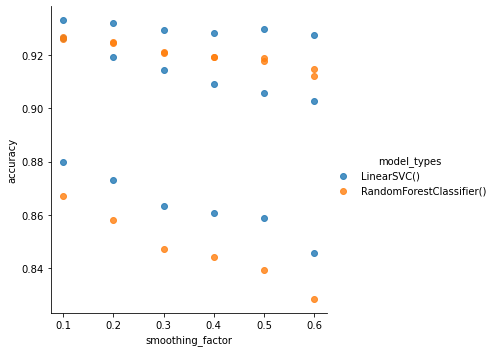

In [12]:
sns.lmplot(x='smoothing_factor', y='accuracy', data=metrics_df, hue='model_types', fit_reg=False)

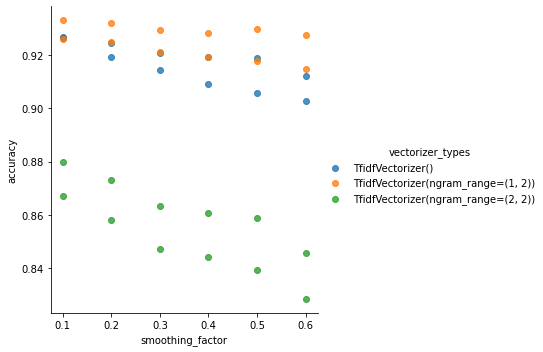

In [13]:
sns.lmplot(x='smoothing_factor', y='accuracy', data=metrics_df, hue='vectorizer_types', fit_reg=False)

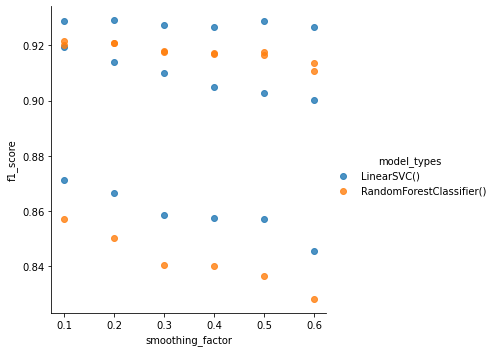

In [14]:
sns.lmplot(x='smoothing_factor', y='f1_score', data=metrics_df, hue='model_types', fit_reg=False)

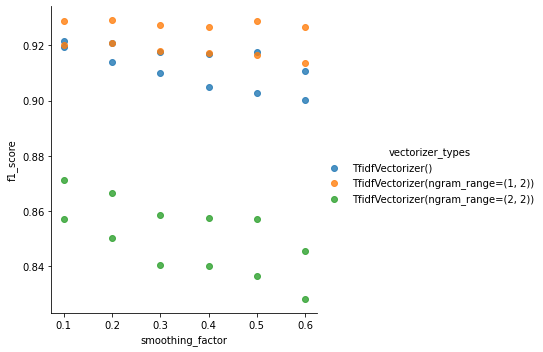

In [15]:
sns.lmplot(x='smoothing_factor', y='f1_score', data=metrics_df, hue='vectorizer_types', fit_reg=False)

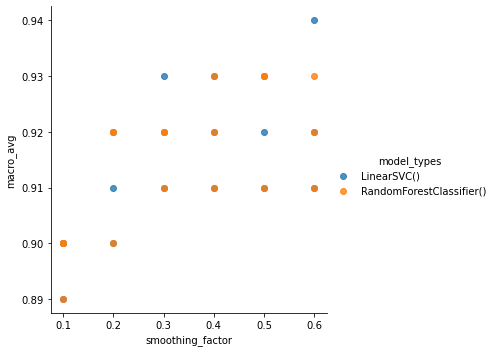

In [16]:
sns.lmplot(x='smoothing_factor', y='macro_avg', data=metrics_df, hue='model_types', fit_reg=False)

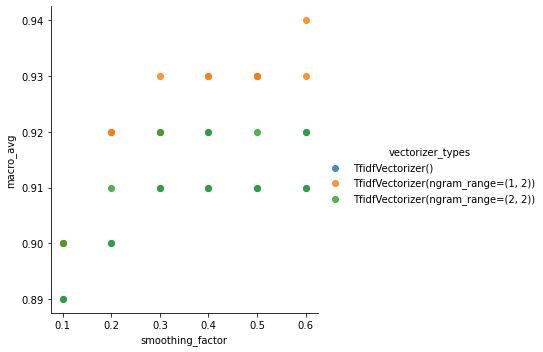

In [17]:
sns.lmplot(x='smoothing_factor', y='macro_avg', data=metrics_df, hue='vectorizer_types', fit_reg=False)

# Balancing Between Precision and Recall:
#### Precision is the ratio of correctly predicted positive observations to the total predicted positives.
* Formula: Precision = TP / (TP + FP)
* Interpretation: Precision answers the question, "Out of all instances predicted as positive, how many are actually positive?" It focuses on the accuracy of positive predictions.

#### Recall (Sensitivity or True Positive Rate) is the ratio of correctly predicted positive observations to the total actual positives.
* Formula: Recall = TP / (TP + FN)
* Interpretation: Recall answers the question, "Out of all actual positives, how many were correctly predicted?" It measures the model's ability to capture all positive instances.

#### The F1-score is the weighted mean of precision and recall. It provides a balance between precision and recall.
* Formula: F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
* Interpretation: F1-Score considers both false positives and false negatives and provides a single score that balances precision and recall. It is especially useful when there is an imbalance between classes.

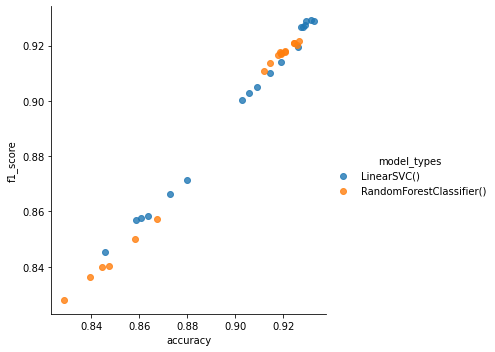

In [18]:
sns.lmplot(x='accuracy', y='f1_score', data=metrics_df, hue='model_types', fit_reg=False)

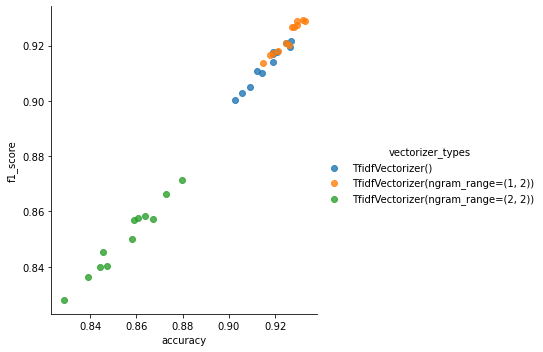

In [19]:
sns.lmplot(x='accuracy', y='f1_score', data=metrics_df, hue='vectorizer_types', fit_reg=False)

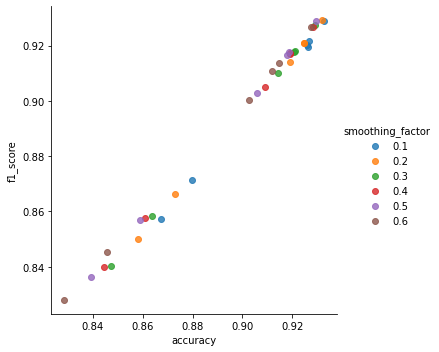

In [20]:
sns.lmplot(x='accuracy', y='f1_score', data=metrics_df, hue='smoothing_factor', fit_reg=False)

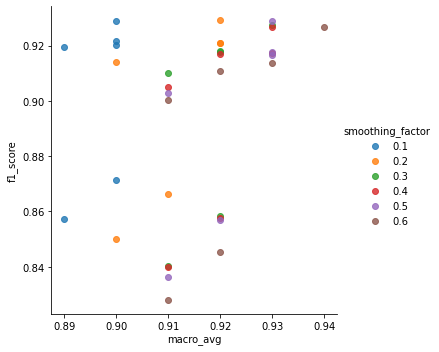

In [21]:
sns.lmplot(x='macro_avg', y='f1_score', data=metrics_df, hue='smoothing_factor', fit_reg=False)

# Model Types and Vector Types
#### It appears that the Support Vector Machine modeling method worked best, on average

In [22]:
def heat_matrix(vals, rows, cols, metrics_df):
    heatmap_data = metrics_df.pivot_table(values=vals, index=rows, 
                                      columns=cols, aggfunc='mean')

    # Create a heatmap using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, cmap='PuBuGn', fmt=".2f", linewidths=.5)

    # Add labels and title
    plt.xlabel(cols)
    plt.ylabel(rows)
    plt.title(f'{vals} Heatmap')

    # Tilt x-axis tick labels
    plt.xticks(rotation=30, ha='right') 


    # Display the plot
    plt.show()

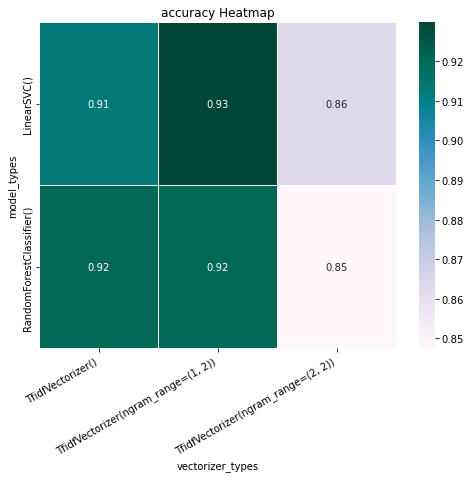

In [23]:
heat_matrix(vals = 'accuracy', rows= 'model_types', cols= 'vectorizer_types', metrics_df = metrics_df)

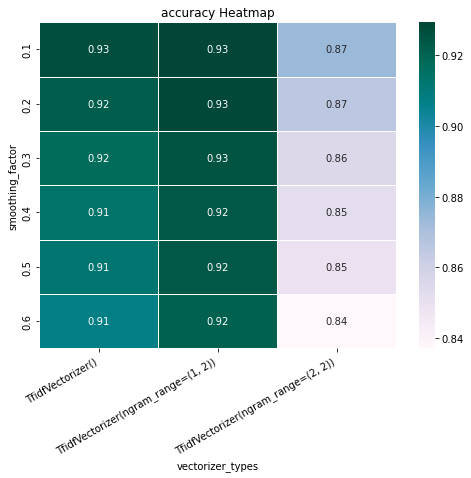

In [24]:
heat_matrix(vals = 'accuracy', rows= 'smoothing_factor', cols= 'vectorizer_types', metrics_df = metrics_df)

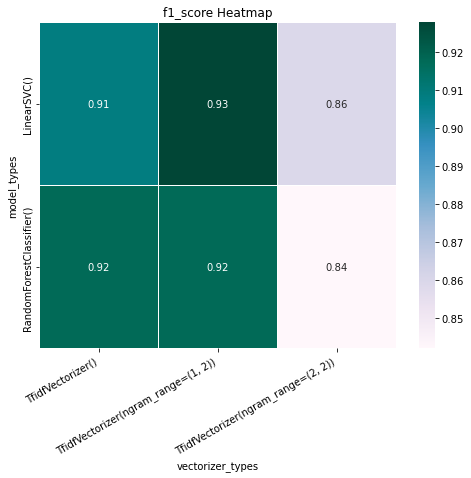

In [25]:
heat_matrix(vals = 'f1_score', rows= 'model_types', cols= 'vectorizer_types', metrics_df = metrics_df)

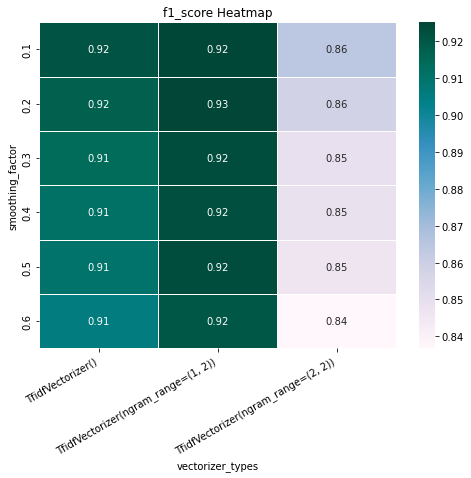

In [26]:
heat_matrix(vals = 'f1_score', rows= 'smoothing_factor', cols= 'vectorizer_types', metrics_df = metrics_df)

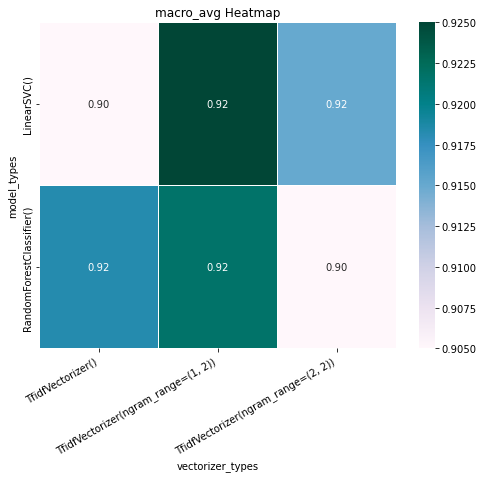

In [27]:
heat_matrix(vals = 'macro_avg', rows= 'model_types', cols= 'vectorizer_types', metrics_df = metrics_df)

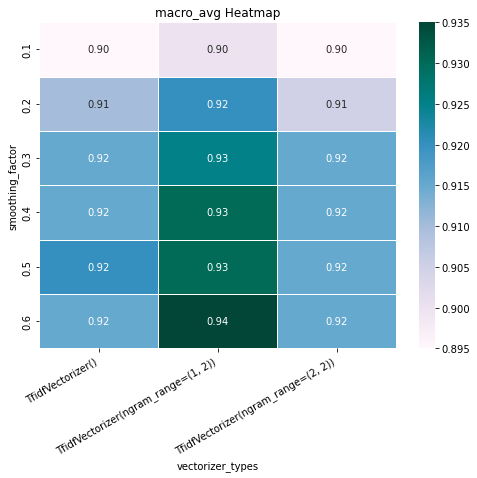

In [28]:
heat_matrix(vals = 'macro_avg', rows= 'smoothing_factor', cols= 'vectorizer_types', metrics_df = metrics_df)

# FINDING OPTIMUM
We would like to find the max f1 AND max macro_avg AND max original data percentage

### Weighted Scoring Example:
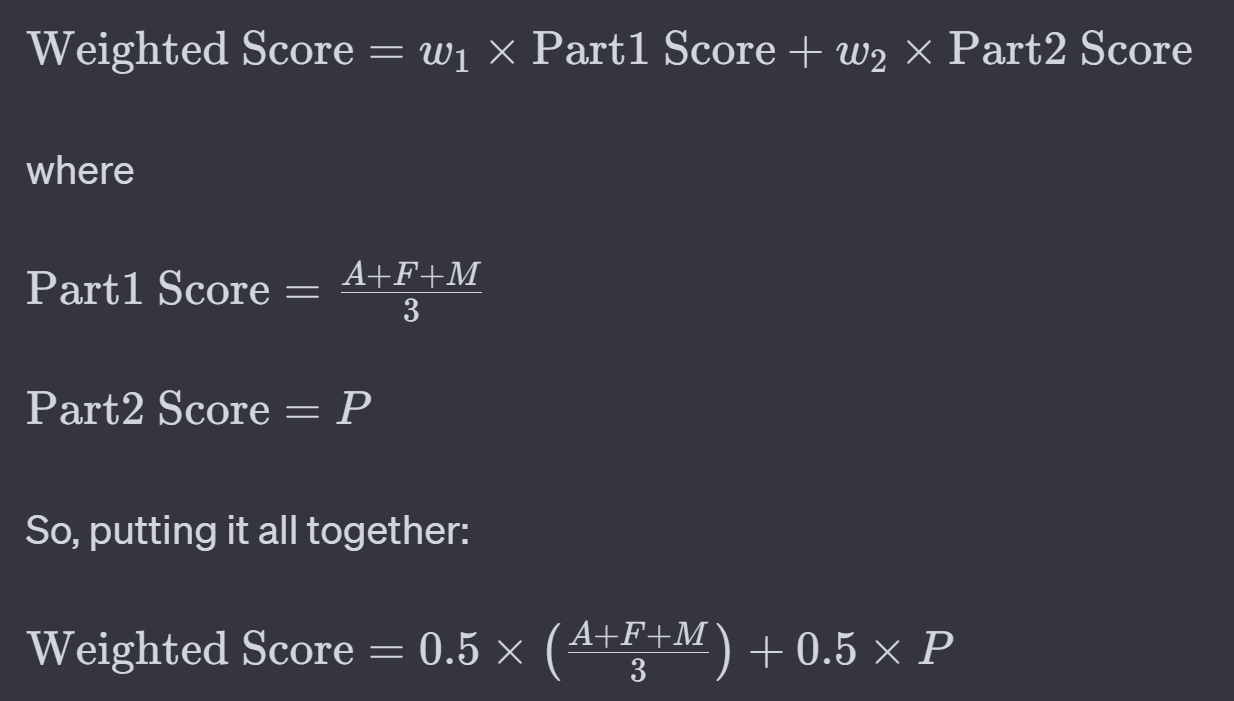

In [29]:
#Make a graded_df
#HELPER FUNCTIONS-----------------------
def standardize_col(col,temp_df):
    """
    takes a numeric column name and the df it is in
    returns a standardized column scaled to values 0-1
    """
    # Extract the column to be standardized
    column_to_scale = temp_df[col].values.reshape(-1, 1)

    # Create a MinMaxScaler
    scaler = MinMaxScaler()

    # Fit the scaler and transform the column and return
    return scaler.fit_transform(column_to_scale)

def partitioned_weighted_scoring(df, parts, weights):
    """
    takes lists of numeric column parts and the corresponding weights of each part,
        along with the df containing columns
    calculates and returns the weighted score:
        Weighted Score = SUM(weight[i]*mean(parts[i]))
    """
    part_scores = dict()
    for i,p in enumerate(parts):
        part_averages = df[p].mean(axis=1)
        part_scores["weighted_"+str(p)] = weights[i]*part_averages
    #set up individual score parts in a df
    scores_df = pd.DataFrame(part_scores)
    #return the full total weighted scores of the partitions
    return scores_df.mean(axis=1)   
    
# ---------------------------------------
#focus on only rows with original data
merged_a = merged_df[merged_df['data_type'] == 'original'].copy()
#standardize grading values
cols_to_standardize = [
    'accuracy',
    'f1_score',
    'macro_avg',
    'data_percentage'
]
for col_name in cols_to_standardize:
    merged_a[f'standardized_{col_name}'] = standardize_col(col_name,merged_a)

#grade models
grading_cols = [
    "standardized_accuracy",
    "standardized_f1_score",
    "standardized_macro_avg",
    "standardized_data_percentage"
]
# Specify the three columns for creating the group
group_columns = ['model_names', 'smoothing_factor', 'model_types', 'vectorizer_types']
#ensure groups are recognized as strings
merged_a[group_columns] = merged_a[group_columns].astype(str)

# Use groupby to create a group based on the specified columns
merged_b = merged_a.groupby('model_names')[grading_cols].mean()
#parse out categories and build the final df... again...
smooth_factors = [x[-3:] for x in merged_b.index]
model_types = [x.split(' - ')[0] for x in merged_b.index]
vectorizer_types = [x.split(' - ')[1].split(' smooth')[0] for x in merged_b.index]

merged_b['smoothing_factor'] = smooth_factors
merged_b['model_types'] = model_types
merged_b['vectorizer_types'] = vectorizer_types

merged_b['smoothing_factor'] = merged_b['smoothing_factor'].astype(float)
merged_b['model_types'] = merged_b['model_types'].astype('category')
merged_b['vectorizer_types'] = merged_b['vectorizer_types'].astype('category')

#grade models
parts = [
    ['standardized_accuracy','standardized_f1_score'],
    ['standardized_macro_avg'],
    ['standardized_data_percentage']
]
merged_b['model_grade'] = partitioned_weighted_scoring(merged_b, 
                                                       parts, 
                                                       weights = [(1/3),(1/3),(1/3)]
                                                      )
merged_c = merged_b.sort_values(by = "model_grade", ascending = False)
merged_c['standardized_grade'] = standardize_col("model_grade",merged_c)
merged_c

,standardized_accuracy,standardized_f1_score,standardized_macro_avg,standardized_data_percentage,smoothing_factor,model_types,vectorizer_types,model_grade,standardized_grade
model_names,,,,,,,,,
"LinearSVC() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.6",0.947293,0.977699,1.0,0.337876,0.6,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))",0.255597,1.000000
"LinearSVC() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.3",0.965980,0.983982,0.8,0.391027,0.3,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))",0.240668,0.914007
"LinearSVC() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.4",0.954515,0.977556,0.8,0.367171,0.4,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))",0.237023,0.893014
"LinearSVC() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.5",0.967417,0.997118,0.8,0.350397,0.5,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))",0.236963,0.892668
"RandomForestClassifier() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.4",0.868750,0.883037,0.8,0.367171,0.4,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(1, 2))",0.227007,0.835323
RandomForestClassifier() - TfidfVectorizer() smooth_factor 0.5,0.865836,0.885750,0.8,0.350397,0.5,RandomForestClassifier(),TfidfVectorizer(),0.225132,0.824524
"LinearSVC() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.2",0.989970,1.000000,0.6,0.428427,0.2,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))",0.224824,0.822746
"RandomForestClassifier() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.5",0.855774,0.876594,0.8,0.350397,0.5,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(1, 2))",0.224065,0.818374
"RandomForestClassifier() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.6",0.824629,0.846218,0.8,0.337876,0.6,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(1, 2))",0.219255,0.790673


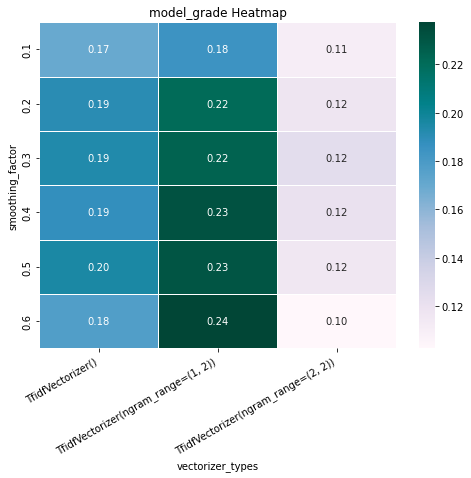

In [38]:
heat_matrix(vals = 'model_grade', 
            rows= 'smoothing_factor', 
            cols= 'vectorizer_types', 
            metrics_df = merged_c
           )

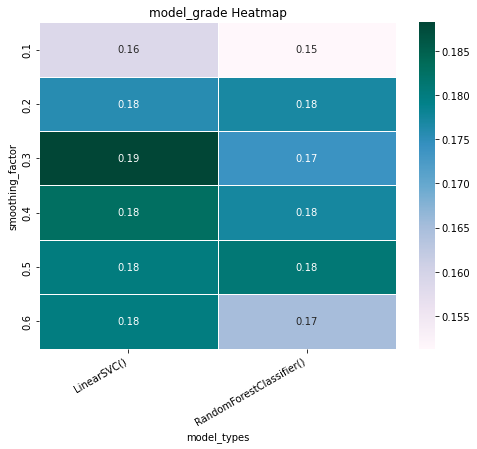

In [39]:
heat_matrix(vals = 'model_grade', 
            rows= 'smoothing_factor', 
            cols= 'model_types', 
            metrics_df = merged_c
           )

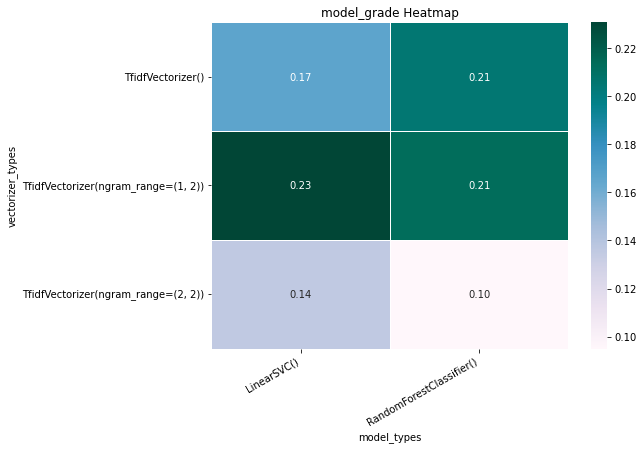

In [40]:
heat_matrix(vals = 'model_grade', 
            rows= 'vectorizer_types', 
            cols= 'model_types', 
            metrics_df = merged_c
           )

# SCALE UP COMMENTS
#### Comments from SMALL scale:
* There appears to be similar performance between character and word vectorizors, but word vectorizers tend to slightly outperform character vectorizers **REMOVE CHAR VECTORIZERS FROM PARAMETERS**
* After running this SMALL scale multiple times, MultinomialNB model has scored lowest each time... but this could change as more data is introduced? **LEAVE ALL MODELS FOR NOW**
#### Comments from MEDIUM scale:
* The top two performing models are LinearSVC and RandomForestClassifier **REMOVE LogisticRegression AND MultinomialNB FROM PARAMETERS**
* Smoothing factor of 0.0 (no augmentation or supplement data what-so-ever) may be skewing accuracy / f1 due to over representation of large categories **REMOVE smoothing_factor OF 0.0 FROM PARAMETERS**
* There appears to be only slight improvement in model grades past a smoothing_factor of 0.5, and that improvement may very likely be due to high synthetic duplications in supplemented training data **SET smoothing_factors TO BE FROM 0.1 - 0.6 (inclusive)**
* The additional 3-word vectors do not show major improvement over 1 and 2-word vectors. **REMOVE 3-word VECTORS FROM PARAMETERS**

#### Comments on LARGE scale:
* LinearSVC and RandomForestClassifier are both competitive
* Best grade returned for the following settings:

In [67]:
df1 = merged_c['model_grade'].head(5)
df1['model_names'] = df1.index
df2 = metrics_df[metrics_df['model_names'].isin(df1['model_names'])]
df3 = pd.merge(df1,df2, on = 'model_names', how="left").dropna()
df3


,model_names,model_grade,accuracy,f1_score,macro_avg,smoothing_factor,model_types,vectorizer_types
0,"LinearSVC() - TfidfVectorizer(ngram_range=(1, ...",0.255597,0.927400,0.926846,0.94,0.6,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))"
1,"LinearSVC() - TfidfVectorizer(ngram_range=(1, ...",0.240668,0.929350,0.927481,0.93,0.3,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))"
2,"LinearSVC() - TfidfVectorizer(ngram_range=(1, ...",0.237023,0.928154,0.926832,0.93,0.4,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))"
3,"LinearSVC() - TfidfVectorizer(ngram_range=(1, ...",0.236963,0.929500,0.928809,0.93,0.5,LinearSVC(),"TfidfVectorizer(ngram_range=(1, 2))"
4,RandomForestClassifier() - TfidfVectorizer(ngr...,0.227007,0.919204,0.917280,0.93,0.4,RandomForestClassifier(),"TfidfVectorizer(ngram_range=(1, 2))"


... As the smoothing factor of 0.6 spiked with the max macro_average, I would be leary of declaring that the best grade. It is very possible that the supplemented data is overfitting the model to the training and test data.
* Based on these grades all having great accuracy and considering the risks of over-supplementing my training data, I would say that the LinearSVC() model with TfidfVectorizer(ngram_range=(1, 2)) and a smoothing factor of 0.3 is optimal. 

## A Look at the TOP MODEL

                    precision    recall  f1-score   support

          DEEP_SKY       0.94      0.97      0.95     11179
              GEAR       0.95      0.96      0.96       840
NOCTILUCENT_CLOUDS       1.00      0.96      0.98       752
   NORTHERN_LIGHTS       0.98      0.98      0.98       730
             OTHER       0.88      0.66      0.76       980
      SOLAR_SYSTEM       0.92      0.94      0.93      3386
       STAR_TRAILS       0.97      0.96      0.96       827
        WIDE_FIELD       0.79      0.70      0.74      1306

          accuracy                           0.93     20000
         macro avg       0.93      0.89      0.91     20000
      weighted avg       0.93      0.93      0.93     20000

PLOTTING CATEGORIES


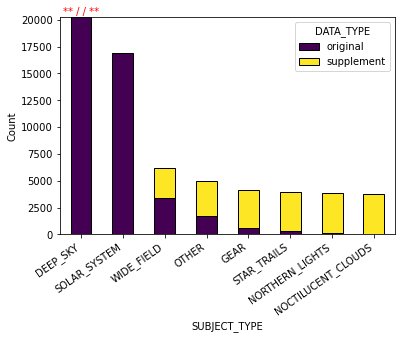

    data_type  sub_counts  percent (%)
0    original       79335        79.33
1  supplement       20662        20.66


data_type,Original Data (%),Supplement Data (%)
Subject Type Category,,
DEEP_SKY,100.00,0.00
SOLAR_SYSTEM,100.00,0.00
WIDE_FIELD,55.77,44.23
OTHER,34.27,65.73
GEAR,13.89,86.11
STAR_TRAILS,7.00,93.00
NORTHERN_LIGHTS,3.00,97.00
NOCTILUCENT_CLOUDS,0.77,99.23


In [123]:
select_model = 'LinearSVC() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.3'
print(all_models[select_model]['report'])
sf = float(select_model[-3:])
c_df = characteristics_df[characteristics_df.smoothing_factor == sf]
category1 = 'subject_type'
category2 = 'data_type'
total_counts = 'sub_counts'
two_category_histogram(category1, category2, total_counts, c_df, print_it = True)

f_df = c_df.groupby('data_type')['sub_counts'].sum().reset_index()
f_df['percent (%)'] = ((f_df['sub_counts']/size)*100).round(2)
print(f_df)

d_df = c_df.pivot_table(values='data_percentage', 
                        index='subject_type', 
                        columns='data_type', aggfunc='mean')
d_df = d_df.rename_axis('Subject Type Category')
d_df = d_df.rename(columns={
    'original':'Original Data (%)',
    'supplement':'Supplement Data (%)'
})
d_df = d_df.fillna(0)
(d_df.sort_values(by='Original Data (%)',ascending = False)*100).round(2)

## A Look at an ALTERNATIVE MODEL

                    precision    recall  f1-score   support

          DEEP_SKY       0.91      0.94      0.93      7380
              GEAR       0.95      0.98      0.97      1569
NOCTILUCENT_CLOUDS       1.00      0.96      0.98      1482
   NORTHERN_LIGHTS       0.99      0.99      0.99      1517
             OTHER       0.91      0.79      0.84      1657
      SOLAR_SYSTEM       0.92      0.94      0.93      3034
       STAR_TRAILS       0.98      0.97      0.98      1522
        WIDE_FIELD       0.84      0.82      0.83      1839

          accuracy                           0.93     20000
         macro avg       0.94      0.92      0.93     20000
      weighted avg       0.93      0.93      0.93     20000

PLOTTING CATEGORIES


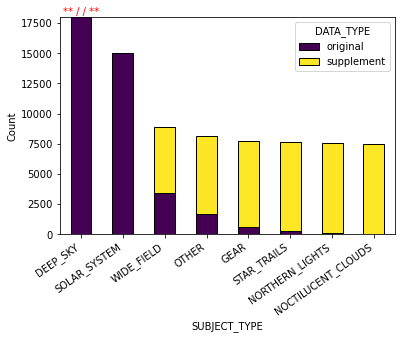

    data_type  sub_counts  percent (%)
0    original       58670        58.67
1  supplement       41330        41.33


data_type,Original Data (%),Supplement Data (%)
Subject Type Category,,
DEEP_SKY,100.00,0.00
SOLAR_SYSTEM,100.00,0.00
WIDE_FIELD,38.66,61.34
OTHER,20.69,79.31
GEAR,7.46,92.54
STAR_TRAILS,3.63,96.37
NORTHERN_LIGHTS,1.52,98.48
NOCTILUCENT_CLOUDS,0.39,99.61


In [124]:
select_model = 'LinearSVC() - TfidfVectorizer(ngram_range=(1, 2)) smooth_factor 0.6'
print(all_models[select_model]['report'])
sf = float(select_model[-3:])
c_df = characteristics_df[characteristics_df.smoothing_factor == sf]
category1 = 'subject_type'
category2 = 'data_type'
total_counts = 'sub_counts'
two_category_histogram(category1, category2, total_counts, c_df, print_it = True)

f_df = c_df.groupby('data_type')['sub_counts'].sum().reset_index()
f_df['percent (%)'] = ((f_df['sub_counts']/size)*100).round(2)
print(f_df)

d_df = c_df.pivot_table(values='data_percentage', 
                        index='subject_type', 
                        columns='data_type', aggfunc='mean')
d_df = d_df.rename_axis('Subject Type Category')
d_df = d_df.rename(columns={
    'original':'Original Data (%)',
    'supplement':'Supplement Data (%)'
})
d_df = d_df.fillna(0)

(d_df.sort_values(by='Original Data (%)',ascending = False)*100).round(2)

# The 10 Worst Models from The Returned Models

In [128]:
merged_c['model_grade'].tail(10)

model_names
LinearSVC() - TfidfVectorizer(ngram_range=(2, 2)) smooth_factor 0.5                 0.137630
LinearSVC() - TfidfVectorizer(ngram_range=(2, 2)) smooth_factor 0.2                 0.136739
LinearSVC() - TfidfVectorizer(ngram_range=(2, 2)) smooth_factor 0.1                 0.128878
LinearSVC() - TfidfVectorizer(ngram_range=(2, 2)) smooth_factor 0.6                 0.122878
RandomForestClassifier() - TfidfVectorizer(ngram_range=(2, 2)) smooth_factor 0.3    0.104493
RandomForestClassifier() - TfidfVectorizer(ngram_range=(2, 2)) smooth_factor 0.4    0.100253
RandomForestClassifier() - TfidfVectorizer(ngram_range=(2, 2)) smooth_factor 0.2    0.097675
RandomForestClassifier() - TfidfVectorizer(ngram_range=(2, 2)) smooth_factor 0.5    0.093622
RandomForestClassifier() - TfidfVectorizer(ngram_range=(2, 2)) smooth_factor 0.1    0.092203
RandomForestClassifier() - TfidfVectorizer(ngram_range=(2, 2)) smooth_factor 0.6    0.081986
Name: model_grade, dtype: float64

... All worst models have a 2-word (and 2-word only) vectorizer 

# TESTING BLOCKS

In [33]:
crashme

NameError: name 'crashme' is not defined

In [95]:
c_df

,subject_type,data_type,sub_counts,total_counts,data_percentage,smoothing_factor
28,DEEP_SKY,original,56324,56324,1.000000,0.3
29,GEAR,original,577,4153,0.138936,0.3
30,GEAR,supplement,3576,4153,0.861064,0.3
31,NOCTILUCENT_CLOUDS,original,29,3769,0.007694,0.3
32,NOCTILUCENT_CLOUDS,supplement,3740,3769,0.992306,0.3
33,NORTHERN_LIGHTS,original,115,3829,0.030034,0.3
34,NORTHERN_LIGHTS,supplement,3714,3829,0.969966,0.3
35,OTHER,original,1691,4935,0.342655,0.3
36,OTHER,supplement,3244,4935,0.657345,0.3
37,SOLAR_SYSTEM,original,16893,16893,1.000000,0.3


In [105]:
d_df = c_df.pivot_table(values='data_percentage', 
                        index='subject_type', 
                        columns='data_type', aggfunc='mean')
d_df = d_df.rename_axis('Subject Type Category')
d_df = d_df.rename(columns={
    'original':'Original Data (%)',
    'supplement':'Supplement Data (%)'
})
d_df = d_df.fillna(0)
(d_df.sort_values(by='Original Data (%)',ascending = False)*100).round(2)

data_type,Original Data (%),Supplement Data (%)
Subject Type Category,,
DEEP_SKY,100.00,0.00
SOLAR_SYSTEM,100.00,0.00
WIDE_FIELD,55.77,44.23
OTHER,34.27,65.73
GEAR,13.89,86.11
STAR_TRAILS,7.00,93.00
NORTHERN_LIGHTS,3.00,97.00
NOCTILUCENT_CLOUDS,0.77,99.23


In [116]:
help(pd.group)

AttributeError: module 'pandas' has no attribute 'group'

In [122]:
f_df = c_df.groupby('data_type')['sub_counts'].sum().reset_index()
f_df['percent (%)'] = ((f_df['sub_counts']/size)*100).round(2)
print(f_df)

    data_type  sub_counts  percent (%)
0    original       58670        58.67
1  supplement       41330        41.33


In [94]:
import pandas as pd

# Create a sample DataFrame
data = {
    'catA': ['A', 'A', 'B', 'B', 'A'],
    'catB': ['X', 'Y', 'X', 'Y', 'Y'],
    'nums1': [10, 20, 30, 40, 50]
}

df = pd.DataFrame(data)

# Create a pivot table to represent the result as a matrix
result_matrix = df.pivot_table(values='nums1', index='catA', columns='catB', aggfunc='mean')

# Display the resulting matrix
print(result_matrix)


catB   X   Y
catA        
A     10  35
B     30  40


In [ ]:
merged_df[merged_df['data_type'] == 'original']

In [ ]:
the_return['data_characteristics'][0]['data_characteristics smoothed (0.0)']

In [ ]:
import pandas as pd

# Sample DataFrame
data = {
    'cat1': ['A', 'A', 'B', 'B', 'C', 'C', 'A', 'B', 'C'],
    'cat2': ['X', 'Y', 'X', 'Y', 'X', 'Y', 'X', 'Y', 'X'],
    'counts': [10, 15, 20, 25, 30, 35, 5, 15, 25]
}

tdf = pd.DataFrame(data)

# Calculate the total counts for each cat1 and cat2 combination
total_counts = tdf.groupby(['cat1', 'cat2'])['counts'].sum().reset_index(name='total_counts')

# Calculate the total counts for each cat1
total_counts_cat1 = tdf.groupby('cat1')['counts'].sum().reset_index(name='total_counts_cat1')

# Merge the two DataFrames to get total_counts for each cat1 and cat2 combination
merged_df = pd.merge(total_counts, total_counts_cat1, on='cat1')

# Calculate the percentage column
merged_df['percentage'] = (merged_df['total_counts'] / merged_df['total_counts_cat1']) * 100

# Drop unnecessary columns
result_df = merged_df[['cat1', 'cat2', 'percentage']]

print(result_df)

### ... The idea here is to merge each accuracy df with the respective cat1 subject_type along side
####### ... along side the percentage of "supplemental" fake data...


In [ ]:
#How many df do we have?
the_count = len(the_return['data_characteristics'])
#Loop through each of these aggregated df
for i in range(0,the_count):
    #what is the current df name?
    df_name = [x for x in the_return['data_characteristics'][i]][0]
    #get the df
    agg_df = the_return['data_characteristics'][i][df_name]
    #append new data as needed
    agg_df['Original_Data'] = np.where(
        agg_df['augmentation'] == 'sampled',
        agg_df['augmentation'], 'supplemented')
    print(df_name)
    two_category_histogram("subject_type", "Original_Data", "Total_Counts", agg_df, print_it = True)
    
    

In [ ]:
the_return['data_characteristics'][1]['data_characteristics smoothed (0.1)']

In [ ]:
import pandas as pd
import numpy as np

# Modified Sample DataFrame
data = {
    'category1': ['A', 'A', 'B', 'B', 'C', 'C', 'D', 'D'],
    'category2': ['X', 'Y', 'X', 'Y', 'X', 'Y', 'X', 'W'],
    'total_counts': [10, 15, 20, 25, 30, 35, 5, 15]
}

tdf = pd.DataFrame(data)

# Create category3 based on category2 values
df['category3'] = np.where(df['category2'].isin(['X', 'W']), df['category2'], 'Other')

print(df)


In [ ]:
two_category_histogram("subject_type", "augmentation", "Total_Counts", test_df, print_it = False)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame
data = {
    'category1': ['A', 'A', 'B', 'B', 'C', 'C'],
    'category2': ['X', 'Y', 'X', 'Y', 'X', 'Y'],
    'total_counts': [10, 15, 20, 25, 30, 35]
}

df = pd.DataFrame(data)

# Pivot the DataFrame to get category2 values as columns
pivot_df = df.pivot_table(index='category1', columns='category2', values='total_counts', aggfunc='sum')

# Plot the stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')

# Set labels and title
ax.set_ylabel('Total Counts')
ax.set_xlabel('Category 1')
ax.set_title('Stacked Bar Chart with Colormap')

# Show the plot
plt.show()


In [ ]:
def two_category_histogram(category1, category2, total_counts, df, print_it = False):
    """
    Where:
        - string category1 counts will be represented as a single bar
        - string ategory2 counts within category1 will be represented by 
            color on the corresponding category1 bar
        - string total_counts is a column containing counts of occurance within both categories
        - df is a data frame with category1 and category2 two columns
    """
    # Create a cross-tabulation (count) of Category1 and Category2
    
    cross_tab = df.pivot_table(index=category1, columns=category2, values=total_counts, aggfunc='sum')

    # Sort the DataFrame based on the counts of Category1 in descending order
    sorted_cross_tab = cross_tab.sum(axis=1).sort_values(ascending=False)
    cross_tab_sorted = cross_tab.loc[sorted_cross_tab.index]

    # Plot the histogram-like graph
    ax = cross_tab_sorted.plot(kind='bar', stacked=True, colormap='viridis', edgecolor='black')
    
    # Set the y-axis limit to be 20% greater than the second largest subject type
    y_limit = 1.2 * sorted_cross_tab.iloc[1]
    plt.ylim(0, y_limit)

    # Annotate bars that exceed the y-axis limit
    for i, (idx, row) in enumerate(cross_tab_sorted.iterrows()):
        if row.sum() > y_limit:
            ax.annotate(f'** / / **', xy=(i, y_limit), ha='center', va='bottom', color='red')
        
    # Customize the plot
    ax.set_xlabel(category1.upper())
    ax.set_ylabel('Count')
    ax.legend(title = category2.upper(), bbox_to_anchor=(1, 1))
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    
    # Tilt x-axis tick labels at a 45-degree angle
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha='right')
    
    if print_it == True:
        # Show the plot
        print("PLOTTING CATEGORIES")
        plt.show()
    
    return(plt)

test_df = the_return['data_characteristics'][3]['data_characteristics smoothed (0.3)']
two_category_histogram("subject_type", "augmentation", "Total_Counts", test_df, print_it = False)

In [ ]:
two_category_histogram("subject_type", "augmentation", "Total_Counts", test_df, print_it = False)